<a href="https://colab.research.google.com/github/sjpark0605/NLP-FYP/blob/main/NER_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%%capture
!pip install datasets evaluate transformers[sentencepiece] seqeval accelerate

In [25]:
import numpy as np
import pandas as pd
import evaluate
import os
import torch

from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import load_from_disk
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, get_scheduler
from accelerate import Accelerator

from seqeval.metrics import classification_report
from collections import defaultdict

In [26]:
# REPLACE CONSTANTS AS APPROPRIATE
MODEL_CHECKPOINT = "bert-base-cased"
TARGET_CORPUS = 'r-300'
PROJECT_DIR = '/content/drive/MyDrive/COMP0029/'
OUTPUT_DIR = PROJECT_DIR + 'outputs/ner/' + TARGET_CORPUS + '/' + MODEL_CHECKPOINT + '/'

In [27]:
device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')

In [28]:
corpus_datasets = load_from_disk(PROJECT_DIR + 'datasets/' + TARGET_CORPUS + '-ner')

In [29]:
ner_feature = corpus_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
pure_label_names = list(set(label.replace("-B", "").replace("-I", "") for label in label_names))

In [30]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [31]:
def align_labels_with_tokens(labels, word_ids):
  new_labels = []

  for word_id in word_ids:
    if word_id is None:
      new_labels.append(-100)
    else:
      new_labels.append(labels[word_id])

  if len(new_labels) != len(word_ids):
    print("FATAL LENGTH MATCHING ERROR")

  return new_labels

In [32]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(
      examples["tokens"], truncation=True, is_split_into_words=True, max_length=128
  )
  all_labels = examples["ner_tags"]
  new_labels = []
  for i, labels in enumerate(all_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs["labels"] = new_labels
  return tokenized_inputs

In [33]:
tokenized_datasets = corpus_datasets.map(
  tokenize_and_align_labels,
  batched=True,
  remove_columns=corpus_datasets["train"].column_names,
)

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

In [34]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [35]:
metric = evaluate.load("seqeval")

In [36]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [37]:
train_dataloader = DataLoader(
  tokenized_datasets["train"],
  collate_fn=data_collator,
  batch_size=32,
)

eval_dataloader = DataLoader(
  tokenized_datasets["valid"], 
  collate_fn=data_collator, 
  batch_size=32,
)

In [38]:
ner_model = AutoModelForTokenClassification.from_pretrained(
  MODEL_CHECKPOINT,
  id2label=id2label,
  label2id=label2id,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [39]:
param_optimizer = list(ner_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [40]:
accelerator = Accelerator()
ner_model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
  ner_model, optimizer, train_dataloader, eval_dataloader
)

In [41]:
epochs = 10
steps_per_epoch = len(train_dataloader)
num_training_steps = epochs * steps_per_epoch

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=0,
  num_training_steps=num_training_steps,
)

In [42]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_predictions, true_labels

In [43]:
def evaluate(eval_dataloader):
    eval_loss_val = 0
    eval_preds, eval_trues = [], []

    ner_model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = ner_model(**batch)
            
        eval_loss_val += outputs.get("loss").item()

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        pred_labels, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=pred_labels, references=true_labels)

        eval_preds.append(pred_labels)
        eval_trues.append(true_labels)

    perf_metrics = metric.compute(suffix=True)

    eval_loss_val /= len(eval_dataloader)     

    return perf_metrics, eval_loss_val, eval_preds, eval_trues

In [44]:
progress_bar = tqdm(range(num_training_steps))

overall_metrics = defaultdict(list)
train_loss_vals, eval_loss_vals = [], []

for epoch in range(epochs):
    # Training
    train_loss_val = 0

    ner_model.train()
    for batch in train_dataloader:
        labels = batch.get("labels")

        outputs = ner_model(**batch)

        logits = outputs.get("logits")
        loss = outputs.loss

        train_loss_val += loss.item()

        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    train_loss_vals.append(train_loss_val / len(train_dataloader))

    # Evaluation
    perf_metrics, eval_loss_val, _, _ = evaluate(eval_dataloader)

    for key in ["precision", "recall", "f1", "accuracy"]:
        overall_metrics[key].append(perf_metrics[f"overall_{key}"] * 100)

    eval_loss_vals.append(eval_loss_val)

  0%|          | 0/690 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
ner_model.save_pretrained(OUTPUT_DIR + 'model/' + TARGET_CORPUS + '-' + MODEL_CHECKPOINT + '-model')

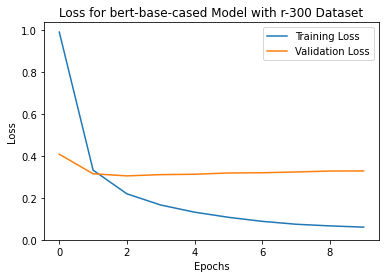

In [46]:
plt.plot(range(epochs), train_loss_vals, label='Training Loss')
plt.plot(range(epochs), eval_loss_vals, label='Validation Loss')

plt.title('Loss for ' + MODEL_CHECKPOINT + ' Model with ' + TARGET_CORPUS + ' Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, None)

plt.legend()

plt.savefig(OUTPUT_DIR + "train_valid_losses.png")

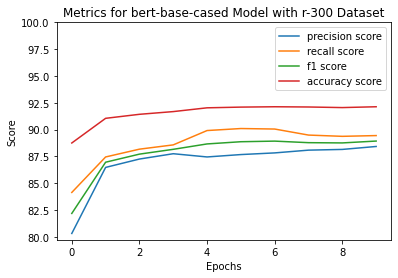

In [47]:
plt.clf()
for key in ["precision", "recall", "f1", "accuracy"]:
  plt.plot(range(epochs), overall_metrics[key], label = key + ' score')

plt.title('Metrics for ' + MODEL_CHECKPOINT + ' Model with ' + TARGET_CORPUS + ' Dataset')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.ylim(None, 100)

plt.legend()
plt.savefig(OUTPUT_DIR + "metrics.png")

In [48]:
_, _, eval_preds, eval_trues = evaluate(eval_dataloader)

pred_labels = [pred_label for batch in eval_preds for pred_label in batch]
true_labels = [true_label for batch in eval_trues for true_label in batch]

report = classification_report(true_labels, pred_labels, suffix=True, output_dict=True)

In [49]:
df = pd.DataFrame(report).transpose()
df.to_csv(OUTPUT_DIR + 'classification_report.csv')